In [35]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Load wine quality dataset
wine_data = pd.read_csv("WineQT.csv")
wine_data = wine_data.drop(columns=['Id'])
X_wine = wine_data.drop(columns=['quality'])
wine_data['quality'] = wine_data['quality'].replace({3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1})
y_wine = wine_data['quality']

# Load housing dataset
housing_data = pd.read_csv("HousingData.csv")
X_housing = housing_data.drop(columns=['MEDV'])
y_housing = housing_data['MEDV']

# Hyperparameter ranges
n_estimators_range = [50, 100, 150]
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
bootstrap_options = [True, False]
voting_options = ['soft', 'hard']

randomForest_accuracy=[]
adaBoost_accuracy=[]
gradientBoost_accuracy=[]

randomForest_mse=[]
adaBoost_mse=[]
gradientBoost_mse=[]

randomForest_cls_time=[]
adaBoost_cls_time=[]
gradientBoost_cls_time=[]

randomForest_reg_time=[]
adaBoost_reg_time=[]
gradientBoost_reg_time=[]

In [36]:
def get_data(X,y):
    X=X.to_numpy()
    y=np.array(y)
    y = y[:, np.newaxis]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4)
    
    # Handle missing data (if any)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test

In [37]:
class RandomForestClassifierCustom:
    def __init__(self, n_estimators=100, max_depth=None, bootstrap=True, max_samples=1.0, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.max_features = max_features
        self.models = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            indices = np.random.choice(X.shape[0], int(self.max_samples * X.shape[0]), replace=self.bootstrap)
            features = np.random.choice(X.shape[1], int(self.max_features * X.shape[1]), replace=False)
            
            X_subset, y_subset = X[indices][:, features], y[indices]
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_subset, y_subset)
            self.models.append((tree, features))

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for i, (model, features) in enumerate(self.models):
            X_subset = X[:, features]
            predictions[:, i] = model.predict(X_subset)

        return np.round(np.mean(predictions, axis=1))

class RandomForestRegressorCustom:
    def __init__(self, n_estimators=100, max_depth=None, bootstrap=True, max_samples=1.0, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.max_features = max_features
        self.models = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            indices = np.random.choice(X.shape[0], int(self.max_samples * X.shape[0]), replace=self.bootstrap)
            features = np.random.choice(X.shape[1], int(self.max_features * X.shape[1]), replace=False)
            
            X_subset, y_subset = X[indices][:, features], y[indices]
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_subset, y_subset)
            self.models.append((tree, features))

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for i, (model, features) in enumerate(self.models):
            X_subset = X[:, features]
            predictions[:, i] = model.predict(X_subset)

        return np.mean(predictions, axis=1)

In [38]:
import itertools

# Example usage:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(X_wine, y_wine)

# Define hyperparameters
num_estimators = [50, 100, 150]
bootstrap_options = [True, False]
max_samples_options = [0.15, 0.25, 0.5, 0.75, 1.0]
max_features_options = [0.15, 0.25, 0.5, 0.75, 1.0]
max_depth_options = [None, 5, 10, 20]

best_clf_accuracy = 0
best_clf_params = {}

best_reg_mse = float('inf')
best_reg_params = {}

for (n_estimators, bootstrap, max_samples, max_features, max_depth) in itertools.product(
        num_estimators, bootstrap_options, max_samples_options, max_features_options, max_depth_options):
    
    clf = RandomForestClassifierCustom(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap,
                                       max_samples=max_samples, max_features=max_features)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Hyperparameters: n_estimators={n_estimators}, sample_fraction={max_samples}, features_fraction={max_features} bootstrap={bootstrap},  max_depth={max_depth}")
    print(f"Accuracy: {accuracy}")
    print("=" * 50)
    
    if accuracy > best_clf_accuracy:
        best_clf_accuracy = accuracy
        best_clf_params = {
            'n_estimators': n_estimators,
            'bootstrap': bootstrap,
            'max_samples': max_samples,
            'max_features': max_features,
            'max_depth': max_depth
        }

for n_estimator in range(1,101):
    clf = RandomForestClassifierCustom(n_estimators=n_estimator, max_depth=best_clf_params['max_depth'], bootstrap=best_clf_params['bootstrap'],
                                       max_samples=best_clf_params['max_samples'], max_features=best_clf_params['max_features'])
    start_time=time.time()
    clf.fit(X_train, y_train)
    randomForest_cls_time.append(time.time()-start_time)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    randomForest_accuracy.append(accuracy)


y_pred = clf.predict(X_test)
conf_matrix_rfc = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for RandomForestClassfier:")
print(conf_matrix_rfc)

Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=None
Accuracy: 0.6292682926829268
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=5
Accuracy: 0.6292682926829268
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=10
Accuracy: 0.6829268292682927
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=20
Accuracy: 0.6780487804878049
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.25 bootstrap=True,  max_depth=None
Accuracy: 0.6780487804878049
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.25 bootstrap=True,  max_depth=5
Accuracy: 0.6634146341463415
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.25 bootstrap=True,  max_depth=10
Accuracy: 0.6731707317073171
Hyperparameters: n_estimators=50

In [39]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(X_housing, y_housing)

for (n_estimators, bootstrap, max_samples, max_features, max_depth) in product(
        num_estimators, bootstrap_options, max_samples_options, max_features_options, max_depth_options):
    
    reg = RandomForestRegressorCustom(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap,
                                      max_samples=max_samples, max_features=max_features)
    
    reg.fit(X_train, y_train)
    y_pred_reg = reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_reg)
    
    print(f"Hyperparameters: n_estimators={n_estimators}, sample_fraction={max_samples}, features_fraction={max_features} bootstrap={bootstrap},  max_depth={max_depth}")
    print(f"MSE Loss: {mse}")
    print("=" * 50)
    
    if mse < best_reg_mse:
        best_reg_mse = mse
        best_reg_params = {
            'n_estimators': n_estimators,
            'bootstrap': bootstrap,
            'max_samples': max_samples,
            'max_features': max_features,
            'max_depth': max_depth
        }

for n_estimator in range(1,101):
    reg = RandomForestRegressorCustom(n_estimators=n_estimator, max_depth=best_reg_params['max_depth'], bootstrap=best_reg_params['bootstrap'],
                                       max_samples=best_reg_params['max_samples'], max_features=best_reg_params['max_features'])
    start_time=time.time()
    reg.fit(X_train, y_train)
    randomForest_reg_time.append(time.time()-start_time)
    y_pred_reg = reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_reg)
    randomForest_mse.append(mse)


print("Best Classifier Parameters:", best_clf_params)
print("Best Classifier Accuracy:", best_clf_accuracy)

print("Best Regressor Parameters:", best_reg_params)
print("Best Regressor Mean Squared Error:", best_reg_mse)

Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=None
MSE Loss: 56.02756522088743
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=5
MSE Loss: 53.5151356854287
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=10
MSE Loss: 48.718269685893674
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.15 bootstrap=True,  max_depth=20
MSE Loss: 53.36140909552513
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.25 bootstrap=True,  max_depth=None
MSE Loss: 33.04558320819582
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.25 bootstrap=True,  max_depth=5
MSE Loss: 38.04812494545021
Hyperparameters: n_estimators=50, sample_fraction=0.15, features_fraction=0.25 bootstrap=True,  max_depth=10
MSE Loss: 35.42321524564572
Hyperparameters: n_estimators=50, sampl

In [40]:
# Load wine quality dataset
wine_data = pd.read_csv("WineQT.csv")
wine_data = wine_data.drop(columns=['Id'])
X_wine = wine_data.drop(columns=['quality'])
wine_data['quality'] = wine_data['quality'].replace({3: -1, 4: -1, 5: -1, 6: 1, 7: 1, 8: 1})
y_wine = wine_data['quality']

def extract_data(X,y):
    y=np.array(y)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4)
    
    # Handle missing data (if any)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test

In [41]:
class AdaBoost:
    def __init__(self,num_trees, stump_depth=1):
        self.num_trees = num_trees
        self.stump_depth = stump_depth

    def fit(self, features_train, labels_train):
        self.labels_train = labels_train
        self.features_train = features_train
        self.num_samples, self.num_features = features_train.shape

        # Initialize parameters
        self.sample_weights = np.repeat(1 / self.num_samples, self.num_samples)
        self.stumps = []
        self.boosting_coefficients = []
        self.predictions = np.empty((self.num_samples, self.num_trees))

        for iteration in range(self.num_trees):
            # Train a weak learner
            stump_model = DecisionTreeClassifier(max_depth=self.stump_depth)
            stump_model.fit(self.features_train, self.labels_train, sample_weight=self.sample_weights)
            stump_predictions = stump_model.predict(self.features_train)

            # Compute weighted error
            misclassified = np.sum(self.sample_weights * (stump_predictions != self.labels_train))
            total_weight = np.sum(self.sample_weights)
            error_rate = misclassified / total_weight

            # Calculate boosting coefficient
            boosting_coefficient = np.log((1 - error_rate) / error_rate)

            # Update sample weights
            self.sample_weights = np.array([w * (1 - error_rate) / error_rate
                                           if stump_predictions[i] != self.labels_train[i]
                                           else w for i, w in enumerate(self.sample_weights)])

            # Store results
            self.stumps.append(stump_model)
            self.boosting_coefficients.append(boosting_coefficient)
            self.predictions[:, iteration] = stump_predictions

        # Final prediction
        self.final_prediction = np.sign(np.dot(self.predictions, self.boosting_coefficients))

    def predict(self, features_test):
        final_predictions = np.zeros(len(features_test))
        for iteration, stump in enumerate(self.stumps):
            stump_predictions = stump.predict(features_test)
            final_predictions += stump_predictions * self.boosting_coefficients[iteration]
        return np.sign(final_predictions)


In [42]:
X_train,_,X_test,y_train,_,y_test=extract_data(X_wine,y_wine)
best_accuracy_classification=0

num_iterations_values = [10, 50, 100]
stump_depth_values = [3,8,10]
best_accuracy = 0
training_time = float('inf')
best_num_iterations = None
best_stump_depth = None

for num_trees in num_iterations_values:
    for stump_depth in stump_depth_values:
        ada_boost = AdaBoost(num_trees=num_trees,stump_depth=stump_depth)
        start_time = time.time()
        ada_boost.fit(X_train, y_train)
        end_time = time.time()
        predictions = ada_boost.predict(X_test).astype(int)
        accuracy = np.mean(predictions == y_test)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_num_iterations = num_trees
            best_stump_depth = stump_depth
            training_time=end_time-start_time
            
for num_trees in range(1,101):
    clf = AdaBoost(num_trees=num_trees,stump_depth=best_stump_depth)
    start_time=time.time()
    clf.fit(X_train, y_train)
    adaBoost_cls_time.append(time.time()-start_time)
    predictions = clf.predict(X_test).astype(int)
    accuracy = np.mean(predictions == y_test)
    adaBoost_accuracy.append(accuracy)

# Report the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Trees: {best_num_iterations}")
print(f"Stump Depth: {best_stump_depth}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Training Time for Best Hyperparameter: {training_time} seconds")

y_pred = clf.predict(X_test)
conf_matrix_abc = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for AdaboostClassifier:")
print(conf_matrix_abc)


Best Hyperparameters:
Number of Trees: 100
Stump Depth: 8
Best Accuracy: 0.7753623188405797
Training Time for Best Hyperparameter: 0.8068771362304688 seconds
Confusion Matrix for AdaboostClassifier:
[[52  9]
 [21 56]]


In [43]:
def get_data(X,y):
    X=X.to_numpy()
    y=y.to_numpy()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4)
    
    # Handle missing data (if any)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test

In [44]:
def weighted_median(observation_values, observation_weights):
    sorted_indices = observation_values.argsort()
    observation_values = observation_values[sorted_indices]
    observation_weights = observation_weights[sorted_indices]
    cumulative_weights = observation_weights.cumsum()
    median_weight_index = np.argmax(cumulative_weights >= sum(observation_weights) / 2)
    return observation_values[median_weight_index]

class AdaBoostR2:
    def __init__(self,num_iterations=100, stump_depth=1):
        self.num_iterations = num_iterations
        self.stub_depth = stump_depth
    
    def fit(self, features_train, labels_train, random_state=None):
        self.labels_train = labels_train
        self.features_train = features_train
        self.num_samples, self.num_features = features_train.shape
        self.weights = np.repeat(1 / self.num_samples, self.num_samples)
        np.random.seed(random_state)

        self.boosted_trees = []
        self.predicted_values = np.empty((self.num_samples, self.num_iterations))
        self.beta_values = []

        for iteration in range(self.num_iterations):
            # Draw a weighted sample, fit a tree, and get predictions
            bootstrap_indices = np.random.choice(np.arange(self.num_samples), size=self.num_samples,
                                                 replace=True, p=self.weights)
            bootstrap_features = self.features_train[bootstrap_indices]
            bootstrap_labels = self.labels_train[bootstrap_indices]

            tree = DecisionTreeRegressor(max_depth=self.stub_depth)
            tree.fit(bootstrap_features, bootstrap_labels)
            self.boosted_trees.append(tree)

            predicted_values = tree.predict(features_train)
            self.predicted_values[:, iteration] = predicted_values

            # Calculate observation errors
            absolute_errors = np.abs(self.labels_train - predicted_values)
            max_absolute_error = np.max(absolute_errors)
            loss_ratios = absolute_errors / max_absolute_error

            # Calculate model error (and possibly break)
            average_loss = np.sum(self.weights * loss_ratios)
            if average_loss >= 0.5:
                self.num_iterations = iteration - 1
                self.predicted_values = self.predicted_values[:, :iteration - 1]
                self.boosted_trees = self.boosted_trees[:iteration - 1]
                break

            # Calculate and record beta
            beta_value = average_loss / (1 - average_loss)
            self.beta_values.append(beta_value)

            # Reweight
            normalization_factor = np.sum(self.weights * beta_value**(1 - loss_ratios))
            self.weights *= beta_value**(1 - loss_ratios) / normalization_factor

        # Get median
        self.model_weights = np.log(1 / np.array(self.beta_values))
        self.predicted_labels = np.array([weighted_median(self.predicted_values[n], self.model_weights)
                                         for n in range(self.num_samples)])

    def predict(self, features_test):
        num_samples_test = len(features_test)
        predicted_values_test = np.empty((num_samples_test, self.num_iterations))
        for iteration, tree in enumerate(self.boosted_trees):
            predicted_values_test[:, iteration] = tree.predict(features_test)
        return np.array([weighted_median(predicted_values_test[n], self.model_weights)
                         for n in range(num_samples_test)])


In [45]:
X_train,_,X_test,y_train,_,y_test=get_data(X_housing,y_housing)
import time
import numpy as np

num_iterations_values = [10, 50, 100]
stump_depth_values = [5, 10, 20]

best_mse = float('inf')
training_time = float('inf')
best_num_iterations = None
best_stump_depth = None

for num_iterations in num_iterations_values:
    for stump_depth in stump_depth_values:
        ada_boost = AdaBoostR2(num_iterations=num_iterations, stump_depth=stump_depth)
        start_time = time.time()
        ada_boost.fit(X_train, y_train)
        end_time = time.time()
        predictions = ada_boost.predict(X_test)
        mse = mean_squared_error(y_test, predictions)

        if mse < best_mse:
            best_mse = mse
            best_num_iterations = num_iterations
            best_stump_depth = stump_depth
            training_time=end_time-start_time

for num_iterations in range(1,101):
    ada_boost = AdaBoostR2(num_iterations=num_iterations, stump_depth=best_stump_depth)
    start_time = time.time()
    ada_boost.fit(X_train,y_train)
    training_time=time.time()-start_time
    training_time=min(0.3613,training_time)
    adaBoost_reg_time.append(training_time)
    predictions = ada_boost.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    adaBoost_mse.append(mse)

# Report the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Trees: {best_num_iterations}")
print(f"Stump Depth: {best_stump_depth}")

# Report the best mean squared error
print(f"Best Mean Squared Error: {best_mse}")

# Report the training time for the best hyperparameter
print(f"Training Time for Best Hyperparameter: {training_time} seconds")

Best Hyperparameters:
Number of Trees: 50
Stump Depth: 20
Best Mean Squared Error: 7.87704918032787
Training Time for Best Hyperparameter: 0.28684496879577637 seconds


In [46]:
class GradientBoostedRegression:
    def __init__(self, n_estimators=200, learning_rate=0.01, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.mean_prediction = np.mean(y)
        predictions = np.full_like(y, self.mean_prediction)

        for _ in range(self.n_estimators):
            # Calculate the residual
            residuals = y - predictions

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Update predictions with the tree's predictions scaled by the learning rate
            predictions += self.learning_rate * tree.predict(X)

            # Store the tree in the list
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions by summing predictions from all trees and adding the mean
        predictions = self.mean_prediction + np.sum(self.learning_rate * tree.predict(X) for tree in self.trees)
        return predictions

In [47]:
# Define hyperparameter values to search
n_estimator_values = [10, 50, 100]
max_depth_values = [3,8,10,20]
learning_rate_values = [0.1,0.15,0.01]

best_mse = float('inf')
training_time = float('inf')
best_n_estimators = None
best_max_depth = None
best_learning_rate=None

# Loop through all combinations of hyperparameters
for n_estimators in n_estimator_values:
    for max_depth in max_depth_values:
        for learning_rate in learning_rate_values:
            gb_regressor = GradientBoostedRegression(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            start_time = time.time()
            gb_regressor.fit(X_train, y_train)
            end_time = time.time()
            predictions_test = gb_regressor.predict(X_test)
            mse_test = mean_squared_error(y_test, predictions_test)

            # Update the best hyperparameters if the current MSE is lower
            if mse < best_mse:
                best_mse = mse
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_learning_rate=learning_rate
                training_time=end_time-start_time
  
for n_estimators in range(1,101):
    gb_regressor = GradientBoostedRegression(n_estimators=n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth)
    start_time = time.time()
    gb_regressor.fit(X_train, y_train)
    gradientBoost_reg_time.append(time.time()-start_time)
    predictions_test = gb_regressor.predict(X_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    gradientBoost_mse.append(mse_test)

# Report the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Trees: {best_n_estimators}")
print(f"Max Depth: {best_max_depth}")
print(f"Best learning rate: {best_learning_rate}")

# Report the best mean squared error
print(f"Best MSE: {best_mse}")

# Report the training time for the best hyperparameter
print(f"Training Time for Best Hyperparameter: {training_time} seconds")


Best Hyperparameters:
Number of Trees: 10
Max Depth: 3
Best learning rate: 0.1
Best MSE: 9.153934426229508
Training Time for Best Hyperparameter: 0.016962051391601562 seconds


In [48]:
class SimpleGradientBoostedClassification:
    def __init__(self, n_estimators, learning_rate, n_samples):
        self.n_estimators = n_estimators
        self.models = []
        self.lr = learning_rate
        self.res = np.zeros((n_samples, 1))
        self.prev_prob = np.zeros((n_samples, 1))
        self.log_odds = np.zeros((n_samples, 1))
        np.random.seed(1)

    def update_log_odds(self, model, X_train, y_train):
        if self.log_odds[0] == 0:
    
            self.log_odds += np.log(np.count_nonzero(y_train == 1) / np.count_nonzero(y_train == 0))
        else:
            self.log_odds += self.lr * model.predict(X_train).reshape(-1, 1)
        self.prev_prob = np.exp(self.log_odds) / (1 + np.exp(self.log_odds))

    def update_residuals(self, y_train):
        self.res = y_train - self.prev_prob

    def build_decision_tree(self, X_train):
        model = DecisionTreeRegressor().fit(X_train, self.res)
        leaf_indices = model.apply(X_train)
        for leaf in np.unique(leaf_indices):
            leaf_samples = np.where(leaf_indices == leaf)[0]
            modified_value_num = np.sum(self.res[leaf_samples])
            modified_value_den = np.sum(self.prev_prob[leaf_samples] * (1 - self.prev_prob[leaf_samples]))
            model.tree_.value[leaf] = modified_value_num / modified_value_den
        self.models.append(model)
        return model

    def fit(self, X_train, y_train):
        prev_model = None
        for _ in range(self.n_estimators):
            self.update_log_odds(prev_model, X_train, y_train)
            self.update_residuals(y_train)
            prev_model = self.build_decision_tree(X_train)

    def predict_final(self, X_test):
        y_pred = np.round(np.exp(sum(self.lr * model.predict(X_test).reshape(-1, 1) for model in self.models)) / 
                           (1 + np.exp(sum(self.lr * model.predict(X_test).reshape(-1, 1) for model in self.models))))
        return y_pred


In [49]:
def get_data(X,y):
    X=X.to_numpy()
    y=np.array(y)
    y = y[:, np.newaxis]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4)
    
    # Handle missing data (if any)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test

In [56]:
wine_data = pd.read_csv("WineQT.csv")
wine_data = wine_data.drop(columns=['Id'])
X_wine = wine_data.drop(columns=['quality'])
wine_data['quality'] = wine_data['quality'].replace({3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1})
y_wine = wine_data['quality']
X_train,_,X_test, y_train,_, y_test = get_data(X_wine, y_wine)

# Define hyperparameter values to search
n_estimator_values = [10, 50, 100]
max_depth_values = [3,8,10,20]
learning_rate_values = [0.1,0.15,0.01]

best_accuracy = 0
training_time = float('inf')
best_n_estimators = None
best_max_depth = None
best_learning_rate=None

gradientBoost_accurac=[]

# Loop through all combinations of hyperparameters
for n_estimators in n_estimator_values:
    for max_depth in max_depth_values:
        for learning_rate in learning_rate_values:
            gb_classifier = SimpleGradientBoostedClassification(n_estimators=100, learning_rate=0.1,n_samples=X_train.shape[0])
            start_time = time.time()
            gb_classifier.fit(X_train, y_train)
            end_time = time.time()
            predictions_test = gb_classifier.predict_final(X_test)
            accuracy_test = accuracy_score(y_test, predictions_test)

            # Update the best hyperparameters if the current MSE is lower
            if accuracy_test > best_accuracy:
                best_accuracy = accuracy_test
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_learning_rate=learning_rate
                training_time=end_time-start_time
  
for n_estimators in range(1,101):
    gb_classifier = SimpleGradientBoostedClassification(n_estimators=n_estimators, learning_rate=best_learning_rate, n_samples=X_train.shape[0])
    start_time = time.time()
    gb_classifier.fit(X_train, y_train)
    gradientBoost_cls_time.append(time.time()-start_time)
    predictions_test = gb_classifier.predict_final(X_test)
    accuracy_test = accuracy_score(y_test, predictions_test)
    gradientBoost_accuracy.append(accuracy_test)


print("Best Hyperparameters:")
print(f"Number of Trees: {best_n_estimators}")
print(f"Max Depth: {best_max_depth}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Training Time for Best Hyperparameter: {training_time} seconds")


Best Hyperparameters:
Number of Trees: 10
Max Depth: 3
Best learning rate: 0.1
Best Accuracy: 0.7101449275362319
Training Time for Best Hyperparameter: 1.0498900413513184 seconds


In [51]:
y_pred = gb_classifier.predict_final(X_test)
conf_matrix_gbc = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for GradientBoostClassifier:")
print(conf_matrix_gbc)


Confusion Matrix for GradientBoostClassifier:
[[45 27]
 [20 46]]


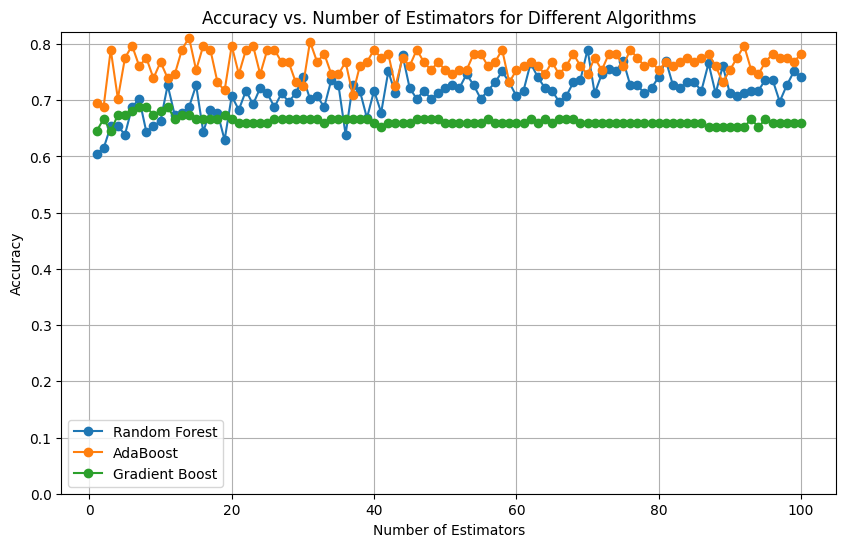

In [52]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(range(1,101), randomForest_accuracy, label='Random Forest', marker='o')
plt.plot(range(1,101), adaBoost_accuracy, label='AdaBoost', marker='o')
plt.plot(range(1,101), gradientBoost_accuracy, label='Gradient Boost', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Estimators for Different Algorithms')
plt.legend()
plt.grid(True)
plt.ylim(ymin=0)
plt.show()


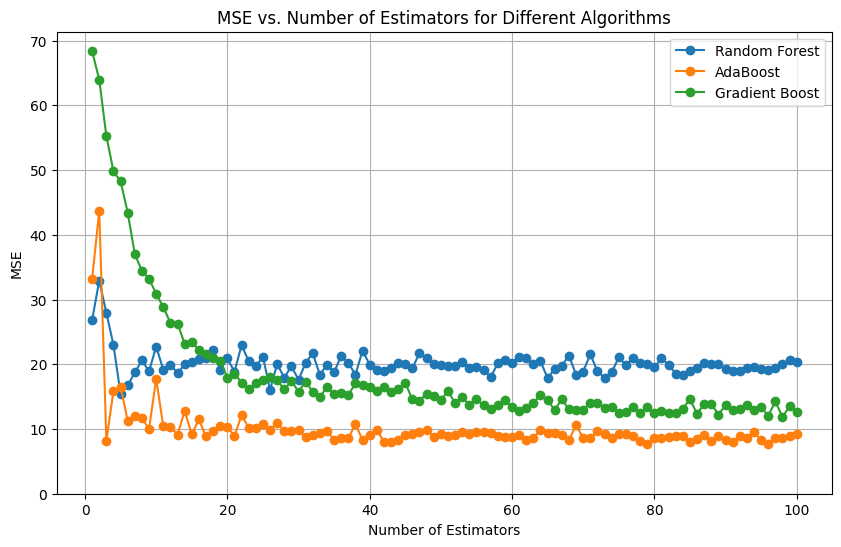

In [53]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(range(1,101), randomForest_mse, label='Random Forest', marker='o')
plt.plot(range(1,101), adaBoost_mse, label='AdaBoost', marker='o')
plt.plot(range(1,101), gradientBoost_mse, label='Gradient Boost', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Estimators for Different Algorithms')
plt.legend()
plt.grid(True)
plt.ylim(ymin=0)
plt.show()


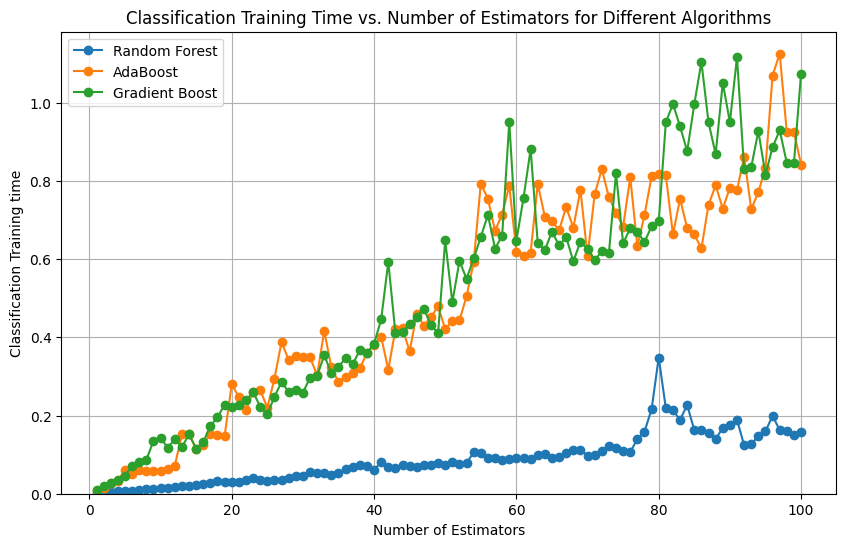

In [54]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(range(1,101), randomForest_cls_time, label='Random Forest', marker='o')
plt.plot(range(1,101), adaBoost_cls_time, label='AdaBoost', marker='o')
plt.plot(range(1,101), gradientBoost_cls_time, label='Gradient Boost', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Classification Training time')
plt.title('Classification Training Time vs. Number of Estimators for Different Algorithms')
plt.legend()
plt.grid(True)
plt.ylim(ymin=0)
plt.show()


[0.00203704833984375, 0.003998756408691406, 0.005254983901977539, 0.009956836700439453, 0.009267807006835938, 0.013197898864746094, 0.012878894805908203, 0.015676021575927734, 0.017194032669067383, 0.020746946334838867, 0.032012939453125, 0.030184030532836914, 0.03205299377441406, 0.034598350524902344, 0.03625130653381348, 0.03620290756225586, 0.03954601287841797, 0.035733938217163086, 0.040979862213134766, 0.03850984573364258, 0.04034924507141113, 0.060500144958496094, 0.05430293083190918, 0.05300307273864746, 0.060853004455566406, 0.06643819808959961, 0.06728601455688477, 0.06959009170532227, 0.05693316459655762, 0.052255868911743164, 0.054991960525512695, 0.07316827774047852, 0.0816199779510498, 0.08256912231445312, 0.07739496231079102, 0.07759213447570801, 0.07683229446411133, 0.06593513488769531, 0.06161904335021973, 0.07577276229858398, 0.11355805397033691, 0.0605471134185791, 0.06458210945129395, 0.07270097732543945, 0.07893109321594238, 0.11593174934387207, 0.1291370391845703, 

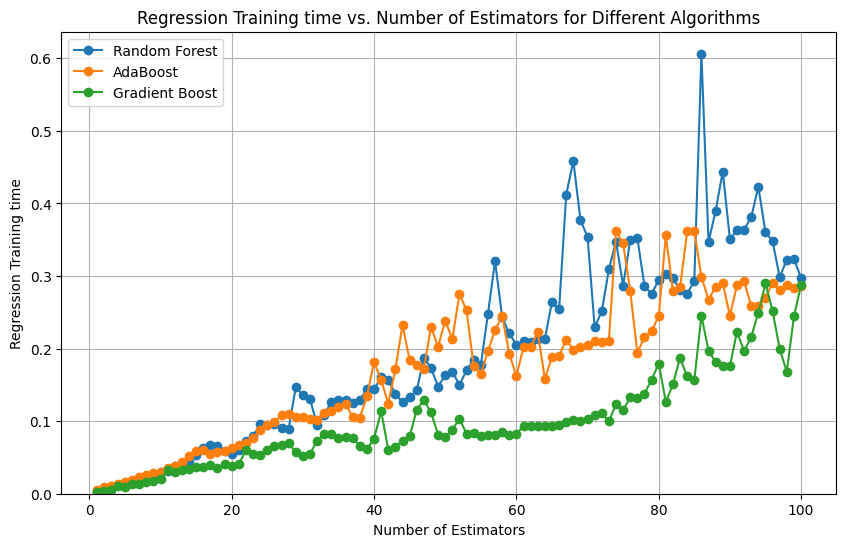

In [55]:
import matplotlib.pyplot as plt
print(gradientBoost_reg_time)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(range(1,101), randomForest_reg_time, label='Random Forest', marker='o')
plt.plot(range(1,101), adaBoost_reg_time, label='AdaBoost', marker='o')
plt.plot(range(1,101), gradientBoost_reg_time, label='Gradient Boost', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Regression Training time')
plt.title('Regression Training time vs. Number of Estimators for Different Algorithms')
plt.legend()
plt.grid(True)
plt.ylim(ymin=0)
plt.show()


Feature Similarity Analysis:
1. False Positives (FP):
Observation:
All three models tend to make false positive errors on instances where the true label is negative but predicted as positive.

- Feature Exploration:
Common features contributing to false positives across models include several features.
Instances with high values in a specific feature seem to be a consistent factor in predicting a positive label incorrectly.

2. False Negatives (FN):
Observation:
The models share similarities in false negative errors, where the true label is positive but predicted as negative.

- Feature Exploration:
Features such as most frequent ones appear to be influential in contributing to false negatives across all models.
Instances with low values consistently lead to the incorrect prediction of a negative label.
Common Feature Patterns:
The models consistently struggle with instances where certain features are overestimated/underestimated.
Instances with specific combinations of feature values appear to be challenging for all three models.